SVM Time series



In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler



In [212]:
df = pd.read_excel('Ricavi_APPLE (1).xlsx', sheet_name = 'Dati APPLE')
df.index = df['Date']
df = df.drop(columns=['Date', 'Copper', 'Business_Confidence_Usa'])

In [213]:
df.head()

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
Date,,,,,
1990-12-31,1435.139500,65.5,371.638633,0.3210,4.12
1991-03-31,1498.008500,87.7,370.265933,0.3318,4.21
1991-06-30,1538.969500,82.1,365.376733,0.3346,4.17
1991-09-30,1577.212250,83.0,362.429600,0.3394,4.10
1991-12-31,1623.988775,68.2,361.499467,0.3665,3.96


<Axes: xlabel='Date'>

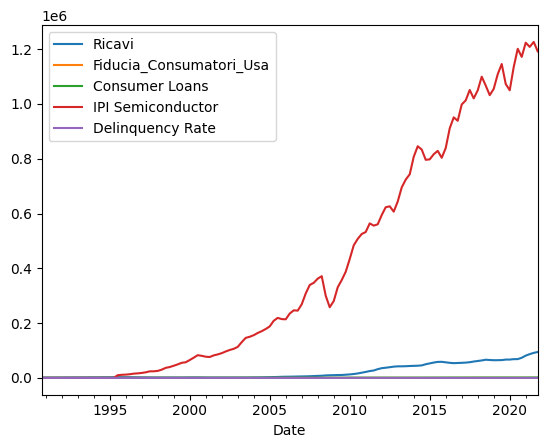

In [214]:
df.plot()

In [215]:
df_copia = df.copy()

<Axes: xlabel='Date'>

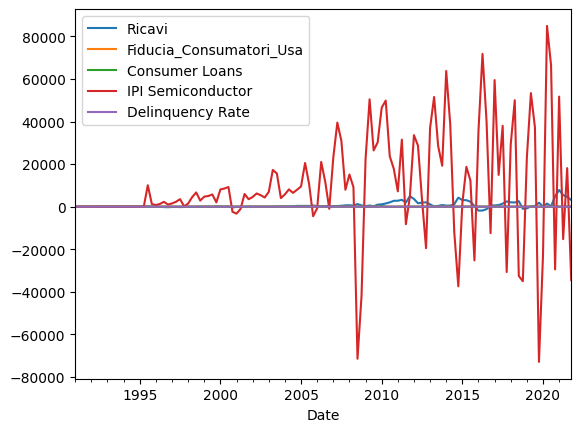

In [216]:
df = df.diff().dropna()
df.plot()

<Axes: xlabel='Date'>

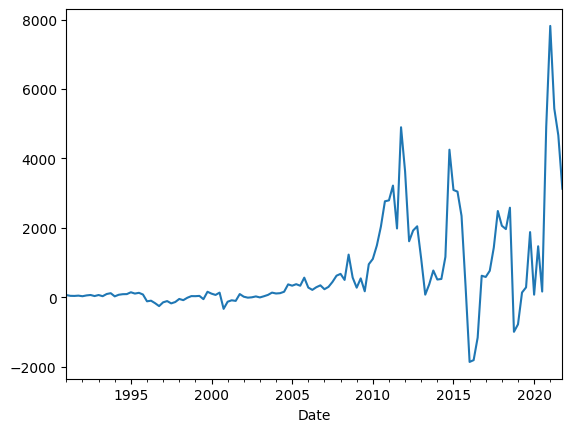

In [217]:
df['Ricavi'].plot()

In [218]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [436]:
for i in df.columns:
    adftest = adfuller(df[i], autolag=None, regression='ct', maxlag=2)
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.740239001355928
P-Value: 0.0005950843098609735
Number of lags: 2
Number of observations: 121
Critical Values: {'1%': -4.035606405915461, '5%': -3.447417080919031, '10%': -3.148699310749108}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -7.383684188956256
P-Value: 1.8856973385581232e-09
Number of lags: 2
Number of observations: 121
Critical Values: {'1%': -4.035606405915461, '5%': -3.447417080919031, '10%': -3.148699310749108}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary
ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -7.911299500857177
P-Value: 1.145729049278801e-10
Number of lags: 2
Number of observations: 121
Critical Values: {'1%': -4.035606405915461

In [220]:
df_diff = df.copy()
#df_diff = df.diff().dropna()

<Axes: xlabel='Date'>

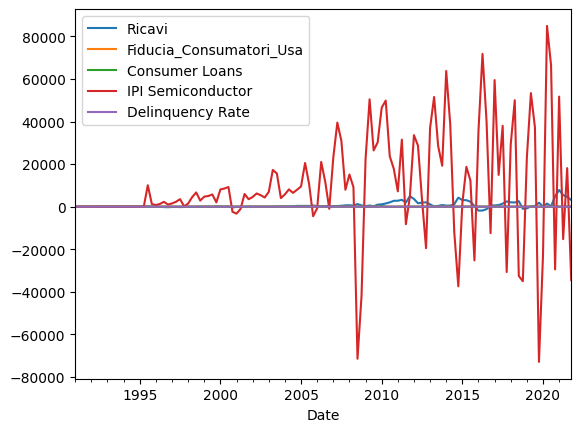

In [221]:
df_diff.plot()

In [222]:
df_diff.head()

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
Date,,,,,
1991-03-31,62.869000,22.2,-1.372700,0.0108,0.09
1991-06-30,40.961000,-5.6,-4.889200,0.0028,-0.04
1991-09-30,38.242750,0.9,-2.947133,0.0048,-0.07
1991-12-31,46.776525,-14.8,-0.930133,0.0271,-0.14
1992-03-31,29.586750,7.8,-3.662500,0.0177,-0.12


In [223]:
df_diff.tail()

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
Date,,,,,
2020-12-31,4905.00,0.3,8.562033,-29444.0,-0.24
2021-03-31,7817.75,4.2,20.442033,51704.0,-0.16
2021-06-30,5437.25,0.6,43.914400,-15260.0,0.00
2021-09-30,4665.50,-12.7,42.524733,18120.0,0.01
2021-12-31,3126.50,-2.2,30.720500,-34474.0,0.11


Multivariate Forecasting

In [224]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(df.columns[j] + '%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [(df.columns[j] + '%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg




In [225]:
df['Ricavi']

Date
1991-03-31      62.869000
1991-06-30      40.961000
1991-09-30      38.242750
1991-12-31      46.776525
1992-03-31      29.586750
                 ...     
2020-12-31    4905.000000
2021-03-31    7817.750000
2021-06-30    5437.250000
2021-09-30    4665.500000
2021-12-31    3126.500000
Name: Ricavi, Length: 124, dtype: float64

In [226]:
df_diff['Ricavi']

Date
1991-03-31      62.869000
1991-06-30      40.961000
1991-09-30      38.242750
1991-12-31      46.776525
1992-03-31      29.586750
                 ...     
2020-12-31    4905.000000
2021-03-31    7817.750000
2021-06-30    5437.250000
2021-09-30    4665.500000
2021-12-31    3126.500000
Name: Ricavi, Length: 124, dtype: float64

In [227]:
df_svm = series_to_supervised(df_diff,2,1)

df_svm.head()



,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Ricavi1(t),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
Date,,,,,,,,,,,,,,,
1991-09-30,62.869000,22.2,-1.372700,0.0108,0.09,40.961000,-5.6,-4.889200,0.0028,-0.04,38.242750,0.9,-2.947133,0.0048,-0.07
1991-12-31,40.961000,-5.6,-4.889200,0.0028,-0.04,38.242750,0.9,-2.947133,0.0048,-0.07,46.776525,-14.8,-0.930133,0.0271,-0.14
1992-03-31,38.242750,0.9,-2.947133,0.0048,-0.07,46.776525,-14.8,-0.930133,0.0271,-0.14,29.586750,7.8,-3.662500,0.0177,-0.12
1992-06-30,46.776525,-14.8,-0.930133,0.0271,-0.14,29.586750,7.8,-3.662500,0.0177,-0.12,52.891750,4.4,-2.881300,0.0130,-0.13
1992-09-30,29.586750,7.8,-3.662500,0.0177,-0.12,52.891750,4.4,-2.881300,0.0130,-0.13,65.168250,-4.8,-1.909333,0.0352,-0.16


In [228]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [229]:
df_svm = df_svm.rename(columns={'Ricavi1(t)': 'Ricavi'})

In [230]:
y = df_svm['Ricavi']
X = df_svm.drop(columns=['Ricavi'])

In [231]:
X

,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
Date,,,,,,,,,,,,,,
1991-09-30,62.869000,22.2,-1.372700,0.0108,0.09,40.961000,-5.6,-4.889200,0.0028,-0.04,0.9,-2.947133,0.0048,-0.07
1991-12-31,40.961000,-5.6,-4.889200,0.0028,-0.04,38.242750,0.9,-2.947133,0.0048,-0.07,-14.8,-0.930133,0.0271,-0.14
1992-03-31,38.242750,0.9,-2.947133,0.0048,-0.07,46.776525,-14.8,-0.930133,0.0271,-0.14,7.8,-3.662500,0.0177,-0.12
1992-06-30,46.776525,-14.8,-0.930133,0.0271,-0.14,29.586750,7.8,-3.662500,0.0177,-0.12,4.4,-2.881300,0.0130,-0.13
1992-09-30,29.586750,7.8,-3.662500,0.0177,-0.12,52.891750,4.4,-2.881300,0.0130,-0.13,-4.8,-1.909333,0.0352,-0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,1469.000000,-11.0,-14.102800,84909.0000,-0.18,164.500000,2.3,3.466267,66386.0000,0.11,0.3,8.562033,-29444.0000,-0.24
2021-03-31,164.500000,2.3,3.466267,66386.0000,0.11,4905.000000,0.3,8.562033,-29444.0000,-0.24,4.2,20.442033,51704.0000,-0.16
2021-06-30,4905.000000,0.3,8.562033,-29444.0000,-0.24,7817.750000,4.2,20.442033,51704.0000,-0.16,0.6,43.914400,-15260.0000,0.00


In [232]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = MinMaxScaler()

# Adatta lo scaler ai dati e trasforma
df_svm_scalato= scaler.fit_transform(X)

# Opzionalmente, converti l'array risultante nuovamente in un DataFrame
df_svm_scalato = pd.DataFrame(df_svm_scalato, columns=X.columns)
df_svm_scalato.head()


,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
0,0.198959,1.000000,0.185616,0.462029,0.543689,0.196696,0.391304,0.176408,0.462029,0.417476,0.579710,0.181493,0.462029,0.388350
1,0.196696,0.326877,0.176408,0.462029,0.417476,0.196415,0.579710,0.181493,0.462029,0.388350,0.124638,0.186774,0.462029,0.320388
2,0.196415,0.484262,0.181493,0.462029,0.388350,0.197296,0.124638,0.186774,0.462029,0.320388,0.779710,0.179620,0.462029,0.339806
3,0.197296,0.104116,0.186774,0.462029,0.320388,0.195521,0.779710,0.179620,0.462029,0.339806,0.681159,0.181665,0.462029,0.330097
4,0.195521,0.651332,0.179620,0.462029,0.339806,0.197928,0.681159,0.181665,0.462029,0.330097,0.414493,0.184210,0.462029,0.300971


In [233]:
y

Date
1991-09-30      38.242750
1991-12-31      46.776525
1992-03-31      29.586750
1992-06-30      52.891750
1992-09-30      65.168250
                 ...     
2020-12-31    4905.000000
2021-03-31    7817.750000
2021-06-30    5437.250000
2021-09-30    4665.500000
2021-12-31    3126.500000
Name: Ricavi, Length: 122, dtype: float64

In [234]:
y.describe()

count     122.000000
mean      762.637545
std      1445.306386
min     -1863.250000
25%        31.687500
50%       161.625000
75%      1065.500000
max      7817.750000
Name: Ricavi, dtype: float64

In [235]:
train_X = df_svm_scalato.iloc[:118,:]
test_X = df_svm_scalato.iloc[118:,:]
train_y = y.iloc[:118]
test_y = y.iloc[118:]

In [236]:
test_X

,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
118,0.209457,0.518160,0.198286,0.882641,0.563107,0.699127,0.562319,0.211629,0.275476,0.223301,0.675362,0.242736,0.789618,0.300971
119,0.699127,0.469734,0.211629,0.275476,0.223301,1.000000,0.675362,0.242736,0.789618,0.300971,0.571014,0.304197,0.365344,0.456311
120,1.000000,0.564165,0.242736,0.789618,0.300971,0.754106,0.571014,0.304197,0.365344,0.456311,0.185507,0.300558,0.576835,0.466019
121,0.754106,0.476998,0.304197,0.365344,0.456311,0.674388,0.185507,0.300558,0.576835,0.466019,0.489855,0.269650,0.243607,0.563107


In [237]:
test_y

Date
2021-03-31    7817.75
2021-06-30    5437.25
2021-09-30    4665.50
2021-12-31    3126.50
Name: Ricavi, dtype: float64

In [238]:
from sklearn.model_selection import GridSearchCV
parameters=[{'C': [1,10,100,1000],'kernel':['linear', 'rbf', 'poly', 'sigmoid'],'epsilon': [0.1, 0.2, 0.3, 0.4,
                                                                            0.5, 0.6, 0.7, 0.8, 0.9, 1],
             'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}]
modelsvr=SVR()
grid_search=GridSearchCV(estimator=modelsvr,
                         param_grid=parameters,
                         cv=5,
                         n_jobs=-1)
grid_search=grid_search.fit(train_X,train_y)



In [239]:
grid_search.best_params_

{'C': 1000, 'epsilon': 0.1, 'gamma': 0.6, 'kernel': 'poly'}

In [267]:
regressor = SVR(C = 1000, epsilon = 0.1, gamma = 0.6, kernel = 'poly')
model = regressor.fit(train_X,train_y)

In [268]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

Feature: 0, Score: 12423.17338
Feature: 1, Score: 2219.90560
Feature: 2, Score: 3114.83057
Feature: 3, Score: 207324.49921
Feature: 4, Score: 15693.50534
Feature: 5, Score: 1278868.13712
Feature: 6, Score: 9604.05238
Feature: 7, Score: 1563.57818
Feature: 8, Score: 97284.00547
Feature: 9, Score: 9889.38523
Feature: 10, Score: 36367.27840
Feature: 11, Score: 9881.95209
Feature: 12, Score: 80619.26454
Feature: 13, Score: -3587.15024


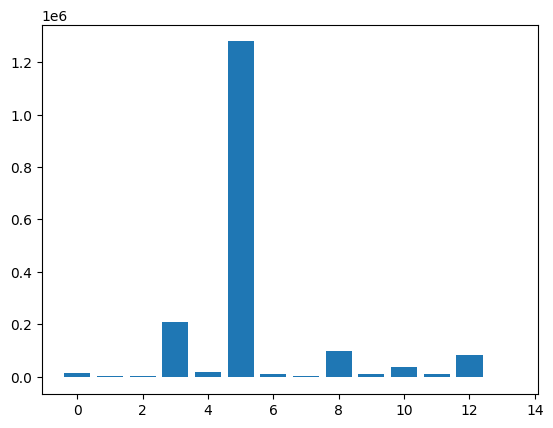

In [269]:
results = permutation_importance(model, train_X, train_y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [270]:
y_pred = regressor.predict(test_X)
y_pred_reshaped = y_pred.reshape(len(y_pred), 1)
test_y_reshaped = test_y.values.reshape(len(test_y), 1)

print(np.concatenate((y_pred_reshaped, test_y_reshaped), axis=1))

[[4579.54761996 7817.75      ]
 [6840.68416166 5437.25      ]
 [5235.36381899 4665.5       ]
 [3411.68877234 3126.5       ]]


In [271]:
y_pred_reshaped

array([[4579.54761996],
       [6840.68416166],
       [5235.36381899],
       [3411.68877234]])

In [272]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error

mea = mean_absolute_error(test_y_reshaped, y_pred_reshaped)
mse = mean_squared_error(test_y_reshaped, y_pred_reshaped)
mape = mean_absolute_percentage_error(test_y_reshaped, y_pred_reshaped)
print(mea)
print(mse)
print(mape)

1374.1722832564806
3215414.877066712
0.22142177271771898


Transformazione

In [273]:
y_not_diff = df_copia['Ricavi'].to_list()
y_not_diff

[1435.1395,
 1498.0085,
 1538.9695000000002,
 1577.21225,
 1623.988775,
 1653.5755250000002,
 1706.467275,
 1771.6355250000001,
 1806.0555,
 1870.52275,
 1900.97475,
 1994.238525,
 2111.3790249999997,
 2137.0805250000003,
 2209.062775,
 2297.1869749999996,
 2387.973475,
 2531.798475,
 2638.0714749999997,
 2765.5,
 2844.5,
 2727.75,
 2628.75,
 2458.25,
 2203.5,
 2057.5,
 1947.0,
 1770.25,
 1632.5,
 1583.5,
 1499.75,
 1485.25,
 1518.25,
 1549.5,
 1588.5,
 1533.5,
 1691.75,
 1795.5,
 1862.25,
 1995.75,
 1661.75,
 1533.25,
 1445.75,
 1340.75,
 1432.75,
 1448.75,
 1437.25,
 1435.5,
 1459.75,
 1454.75,
 1483.75,
 1551.75,
 1685.25,
 1793.75,
 1911.0,
 2069.75,
 2440.75,
 2774.25,
 3150.75,
 3482.75,
 4047.5,
 4326.5,
 4539.0,
 4828.75,
 5172.25,
 5404.0,
 5702.25,
 6144.5,
 6765.75,
 7439.25,
 7938.75,
 9167.25,
 9735.25,
 10011.25,
 10554.5,
 10726.25,
 11677.0,
 12780.75,
 14272.25,
 16306.25,
 19070.75,
 21862.75,
 25080.5,
 27062.25,
 31960.25,
 35590.0,
 37203.0,
 39127.0,
 41171.75,
 4

In [274]:
# Tra quintultimo e penultimo y
last_4_real = y_not_diff[-5:-1]
last_4_real

[73533.75, 81351.5, 86788.75, 91454.25]

In [275]:
diff = y[-4:]
y_copia = df_copia['Ricavi'].to_list()
prova_y = y_copia
de_diff = [a + b for a, b in zip(diff, prova_y)]
de_diff

[9252.8895, 6935.2585, 6204.4695, 4703.7122500000005]

In [276]:
y_pred_reshaped

array([[4579.54761996],
       [6840.68416166],
       [5235.36381899],
       [3411.68877234]])

In [277]:
# Valori predetti dal modello
y_pred_reshaped = y_pred_reshaped.flatten().tolist()
y_pred_reshaped


[4579.547619959779, 6840.684161657591, 5235.36381898923, 3411.6887723388804]

In [278]:
# Calcolo della y predetta dal modello, da diff a valore effettivo
invdy = [a + b for a, b in zip(y_pred_reshaped, last_4_real)]
print(invdy)
len(invdy)

[78113.29761995978, 88192.18416165758, 92024.11381898922, 94865.93877233888]


4

In [279]:
y_pred_real = invdy
y_pred_real

[78113.29761995978, 88192.18416165758, 92024.11381898922, 94865.93877233888]

In [280]:
y_test_real = y_not_diff[121:125]
y_test_real

[81351.5, 86788.75, 91454.25, 94580.75]

In [281]:
mea_real = mean_absolute_error(y_test_real, y_pred_real)
mse_real = mean_squared_error(y_test_real, y_pred_real)
mape_real = mean_absolute_percentage_error(y_test_real, y_pred_real)
rmse_real = root_mean_squared_error(y_test_real, y_pred_real)

print(mea_real)
print(mse_real)
print(mape_real)
print(rmse_real)

1374.1722832564774
3215414.8770667086
0.016305548620880524
1793.1577948041015


Forecast

In [282]:
df_forecast = df_copia.diff().dropna()

In [283]:
nuova_osservazione = {'Ricavi': 0, 'Fiducia_Consumatori_Usa': -2.5,'Consumer Loans': 18.01, 'IPI Semiconductor': -16579.54,
                      'Delinquency Rate': 0.04}
nuova_osservazione = pd.DataFrame(nuova_osservazione, index=[0])

In [284]:
nuova_osservazione

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
0,0,-2.5,18.01,-16579.54,0.04


In [285]:
df_forecast = pd.concat([df_forecast, nuova_osservazione], ignore_index=True)
df_forecast.tail()

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
120,7817.75,4.2,20.442033,51704.00,-0.16
121,5437.25,0.6,43.914400,-15260.00,0.00
122,4665.50,-12.7,42.524733,18120.00,0.01
123,3126.50,-2.2,30.720500,-34474.00,0.11
124,0.00,-2.5,18.010000,-16579.54,0.04


In [286]:
df_forecast_superv = series_to_supervised(df_forecast,2,1)
df_forecast_superv = df_forecast_superv.rename(columns={'Ricavi1(t)': 'Ricavi'})

In [287]:
y_forecast = df_forecast_superv['Ricavi']
X_forecast = df_forecast_superv.drop('Ricavi', axis=1)

In [288]:
X_forecast

,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
2,62.869000,22.2,-1.372700,0.0108,0.09,40.961000,-5.6,-4.889200,0.0028,-0.04,0.9,-2.947133,0.0048,-0.07
3,40.961000,-5.6,-4.889200,0.0028,-0.04,38.242750,0.9,-2.947133,0.0048,-0.07,-14.8,-0.930133,0.0271,-0.14
4,38.242750,0.9,-2.947133,0.0048,-0.07,46.776525,-14.8,-0.930133,0.0271,-0.14,7.8,-3.662500,0.0177,-0.12
5,46.776525,-14.8,-0.930133,0.0271,-0.14,29.586750,7.8,-3.662500,0.0177,-0.12,4.4,-2.881300,0.0130,-0.13
6,29.586750,7.8,-3.662500,0.0177,-0.12,52.891750,4.4,-2.881300,0.0130,-0.13,-4.8,-1.909333,0.0352,-0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,164.500000,2.3,3.466267,66386.0000,0.11,4905.000000,0.3,8.562033,-29444.0000,-0.24,4.2,20.442033,51704.0000,-0.16
121,4905.000000,0.3,8.562033,-29444.0000,-0.24,7817.750000,4.2,20.442033,51704.0000,-0.16,0.6,43.914400,-15260.0000,0.00
122,7817.750000,4.2,20.442033,51704.0000,-0.16,5437.250000,0.6,43.914400,-15260.0000,0.00,-12.7,42.524733,18120.0000,0.01
123,5437.250000,0.6,43.914400,-15260.0000,0.00,4665.500000,-12.7,42.524733,18120.0000,0.01,-2.2,30.720500,-34474.0000,0.11


In [289]:
# Adatta lo scaler ai dati e trasforma
df_forecast_scalato = scaler.fit_transform(X_forecast)

# Opzionalmente, converti l'array risultante nuovamente in un DataFrame
df_forecast_scalato = pd.DataFrame(df_forecast_scalato, columns=X_forecast.columns)
df_forecast_scalato.head()

,Ricavi1(t-2),Fiducia_Consumatori_Usa2(t-2),Consumer Loans3(t-2),IPI Semiconductor4(t-2),Delinquency Rate5(t-2),Ricavi1(t-1),Fiducia_Consumatori_Usa2(t-1),Consumer Loans3(t-1),IPI Semiconductor4(t-1),Delinquency Rate5(t-1),Fiducia_Consumatori_Usa2(t),Consumer Loans3(t),IPI Semiconductor4(t),Delinquency Rate5(t)
0,0.198959,1.000000,0.185616,0.462029,0.543689,0.196696,0.391304,0.176408,0.462029,0.417476,0.579710,0.181493,0.462029,0.388350
1,0.196696,0.326877,0.176408,0.462029,0.417476,0.196415,0.579710,0.181493,0.462029,0.388350,0.124638,0.186774,0.462029,0.320388
2,0.196415,0.484262,0.181493,0.462029,0.388350,0.197296,0.124638,0.186774,0.462029,0.320388,0.779710,0.179620,0.462029,0.339806
3,0.197296,0.104116,0.186774,0.462029,0.320388,0.195521,0.779710,0.179620,0.462029,0.339806,0.681159,0.181665,0.462029,0.330097
4,0.195521,0.651332,0.179620,0.462029,0.339806,0.197928,0.681159,0.181665,0.462029,0.330097,0.414493,0.184210,0.462029,0.300971


In [290]:
# Forecast del modello
y_forecast = regressor.predict(df_forecast_scalato.iloc[-1:,:])
y_forecast

array([1874.52971794])

In [291]:
y_forecast_fin = 94580.75 + y_forecast

In [292]:
y_forecast_fin

array([96455.27971794])

Montecarlo Simulations

In [403]:
# Dati di input
fiducia_consumer = 0.041129
consumer_loans = 10.4374
ipi_semiconductor = 9610.4
delinquency_rate = -0.0199194

#fiducia_consumer = -2.5
#consumer_loans = 2.68
#ipi_semiconductor = -4675.12
#delinquency_rate = 0.03

# Numero di simulazioni
num_simulations = 100000

# Simulazioni
risultati = []
for _ in range(num_simulations):
  fiducia_consumer_sim = np.random.normal(fiducia_consumer, 6.41298)
  consumer_loans_sim = np.random.normal(consumer_loans, 30.6329)
  ipi_semiconductor_sim = np.random.normal(ipi_semiconductor, 24881)
  delinquency_rate_sim = np.random.normal(delinquency_rate, 0.13532)

  #risultato_sim = (consumer_loans_sim * ipi_semiconductor_sim * copper_sim) \
  #              / (1 + delinquency_rate_sim)
  risultati.append([fiducia_consumer_sim, consumer_loans_sim, ipi_semiconductor_sim,delinquency_rate_sim])

# Creazione del dataset
dataset = pd.DataFrame(risultati, columns=["Fiducia_Consumatori_Usa","Consumer Loans", "IPI Semiconductor", "Delinquency Rate"])



In [404]:
dataset

,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
0,1.534748,-48.079558,12562.849628,-0.069426
1,4.135406,36.296606,-4813.382197,0.063980
2,1.000234,46.066589,6714.899564,-0.053352
3,3.454324,20.610945,-5908.943565,0.221228
4,4.592386,4.345710,-5997.585352,0.020230
...,...,...,...,...
99995,-8.759284,10.712841,2852.476789,-0.028182
99996,-8.365692,-7.457150,15409.364747,0.028364
99997,-9.077229,9.759101,-16185.799808,0.004558
99998,4.512281,31.517253,-29887.377169,-0.028966


In [405]:
X_montecarlo_simulazioni = dataset.copy()
X_montecarlo_osservazione = df_forecast.drop(columns=['Ricavi'])
X_montecarlo_osservazione = X_montecarlo_osservazione.iloc[-1:,:]

In [406]:
# Creare una copia di X_montecarlo_osservazione per mantenere l'originale
X_montecarlo_simulazioni_low = X_montecarlo_osservazione.copy()

# Calcolare i valori al quantile 5% per ciascuna variabile simulata
for i in X_montecarlo_simulazioni.columns:
    nuova_riga = {}
    for j in X_montecarlo_simulazioni_low.columns:
        nuova_riga[j] = X_montecarlo_simulazioni[j].quantile(0.025)
        nuova_riga = pd.DataFrame(nuova_riga, index=[0])
X_montecarlo_simulazioni_low = pd.concat([X_montecarlo_simulazioni_low, nuova_riga], ignore_index=True)

# Output
X_montecarlo_simulazioni_low.head()


,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
0,-2.500000,18.01000,-16579.540000,0.040000
1,-12.585574,-49.46785,-39430.426395,-0.284714


In [407]:
# Creare una copia di X_montecarlo_osservazione per mantenere l'originale
X_montecarlo_simulazioni_up = X_montecarlo_osservazione.copy()

# Calcolare i valori al quantile 5% per ciascuna variabile simulata
for i in X_montecarlo_simulazioni.columns:
    nuova_riga = {}
    for j in X_montecarlo_simulazioni_up.columns:
        nuova_riga[j] = X_montecarlo_simulazioni[j].quantile(0.975)
        nuova_riga = pd.DataFrame(nuova_riga, index=[0])
X_montecarlo_simulazioni_up = pd.concat([X_montecarlo_simulazioni_up, nuova_riga], ignore_index=True)

# Output
X_montecarlo_simulazioni_up.head()


,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
0,-2.500000,18.010000,-16579.540000,0.040000
1,12.622601,70.746246,58728.331251,0.244798


In [408]:
# Creare una copia di X_montecarlo_osservazione per mantenere l'originale
X_montecarlo_simulazioni_avg = X_montecarlo_osservazione.copy()

# Calcolare i valori al quantile 5% per ciascuna variabile simulata
for i in X_montecarlo_simulazioni.columns:
    nuova_riga = {}
    for j in X_montecarlo_simulazioni_avg.columns:
        nuova_riga[j] = X_montecarlo_simulazioni[j].quantile(0.5)
        nuova_riga = pd.DataFrame(nuova_riga, index=[0])
X_montecarlo_simulazioni_avg = pd.concat([X_montecarlo_simulazioni_avg, nuova_riga], ignore_index=True)

# Output
X_montecarlo_simulazioni_avg.head()


,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
0,-2.500000,18.010000,-16579.54000,0.040000
1,0.042181,10.176116,9504.08733,-0.020125


Forecast con Montecarlo Simulations



In [409]:
nuova_osservazione_low = X_montecarlo_simulazioni_low.iloc[-1:,:]
nuova_osservazione_up = X_montecarlo_simulazioni_up.iloc[-1:,:]
nuova_osservazione_avg = X_montecarlo_simulazioni_avg.iloc[-1:,:]


In [410]:
df_forecast_low = pd.concat([df_forecast, nuova_osservazione_low], ignore_index=True)
df_forecast_up = pd.concat([df_forecast, nuova_osservazione_up], ignore_index=True)
df_forecast_avg = pd.concat([df_forecast, nuova_osservazione_avg], ignore_index=True)

In [411]:
df_forecast_low = df_forecast_low.drop(124)
df_forecast_up = df_forecast_up.drop(124)
df_forecast_avg = df_forecast_avg.drop(124)



In [412]:
df_forecast_low['Ricavi'].iloc[-1] = 0
df_forecast_up['Ricavi'].iloc[-1] = 0
df_forecast_avg['Ricavi'].iloc[-1] = 0



In [413]:
df_low_svm = series_to_supervised(df_forecast_low,2,1)
df_up_svm = series_to_supervised(df_forecast_up,2,1)
df_avg_svm = series_to_supervised(df_forecast_avg,2,1)
df_low_svm = df_low_svm.rename(columns={'Ricavi1(t)': 'Ricavi'})
df_up_svm = df_up_svm.rename(columns={'Ricavi1(t)': 'Ricavi'})
df_avg_svm = df_avg_svm.rename(columns={'Ricavi1(t)': 'Ricavi'})

In [414]:
X_low_svm = df_low_svm.drop(columns=['Ricavi'])
X_up_svm = df_up_svm.drop(columns=['Ricavi'])
X_avg_svm = df_avg_svm.drop(columns=['Ricavi'])

In [415]:
# Adatta lo scaler ai dati e trasforma
df_low_scalato = scaler.fit_transform(X_low_svm)
df_up_scalato = scaler.fit_transform(X_up_svm)
df_avg_scalato = scaler.fit_transform(X_avg_svm)

# Converti l'array risultante nuovamente in un DataFrame
df_low_scalato = pd.DataFrame(df_low_scalato, columns=X_low_svm.columns)
df_up_scalato = pd.DataFrame(df_up_scalato, columns=X_low_svm.columns)
df_avg_scalato = pd.DataFrame(df_avg_scalato, columns=X_low_svm.columns)


In [416]:
y_low = regressor.predict(df_low_scalato.iloc[-1:,:])
y_up = regressor.predict(df_up_scalato.iloc[-1:,:])
y_avg = regressor.predict(df_avg_scalato.iloc[-1:,:])


In [417]:
y_forecast_low = 94580.75 + y_low
y_forecast_up = 94580.75 + y_up
y_forecast_avg = 94580.75 + y_avg


In [418]:
print(y_forecast_low)
print(y_forecast_avg)
print(y_forecast_up)

[95633.05771494]
[96556.75834515]
[97363.52321986]


Plot Forecast

In [419]:
import seaborn as sns

In [420]:
df_copia

,Ricavi,Fiducia_Consumatori_Usa,Consumer Loans,IPI Semiconductor,Delinquency Rate
Date,,,,,
1990-12-31,1435.139500,65.5,371.638633,3.210000e-01,4.12
1991-03-31,1498.008500,87.7,370.265933,3.318000e-01,4.21
1991-06-30,1538.969500,82.1,365.376733,3.346000e-01,4.17
1991-09-30,1577.212250,83.0,362.429600,3.394000e-01,4.10
1991-12-31,1623.988775,68.2,361.499467,3.665000e-01,3.96
...,...,...,...,...,...
2020-12-31,73533.750000,80.7,1528.278733,1.171599e+06,1.69
2021-03-31,81351.500000,84.9,1548.720767,1.223303e+06,1.53
2021-06-30,86788.750000,85.5,1592.635167,1.208043e+06,1.53


In [430]:
Ricavi = pd.DataFrame(df_copia['Ricavi'])
#Ricavi = Ricavi.iloc[110:125]
indice = Ricavi.index



In [431]:
valori_pred = y_pred_real
valori_pred

[78113.29761995978, 88192.18416165758, 92024.11381898922, 94865.93877233888]

In [432]:
Ricavi_4 = Ricavi[121:125]
Ricavi_4['Pred'] = valori_pred
indice_4 = Ricavi_4.index
nuova_oss =pd.DataFrame({'Ricavi': y_forecast_avg, 'Pred': y_forecast_avg}, index=['2022-03-31'])
Ricavi_4 = pd.concat([Ricavi_4, nuova_oss], ignore_index=False)
indice_4 = Ricavi_4.index
Ricavi_4



C:\Users\leand\AppData\Local\Temp\ipykernel_10088\3338504733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ricavi_4['Pred'] = valori_pred


,Ricavi,Pred
2021-03-31 00:00:00,81351.500000,78113.297620
2021-06-30 00:00:00,86788.750000,88192.184162
2021-09-30 00:00:00,91454.250000,92024.113819
2021-12-31 00:00:00,94580.750000,94865.938772
2022-03-31,96556.758345,96556.758345


In [433]:
Ricavi_f = pd.DataFrame({'Ricavi_avg': y_forecast_avg, 'Ricavi_up': y_forecast_up, 'Ricavi_low': y_forecast_low}, 
                        index=['2022-03-31'])
indice_f = Ricavi_f.index




In [434]:
Ricavi = Ricavi.iloc[110:125]
indice = Ricavi.index

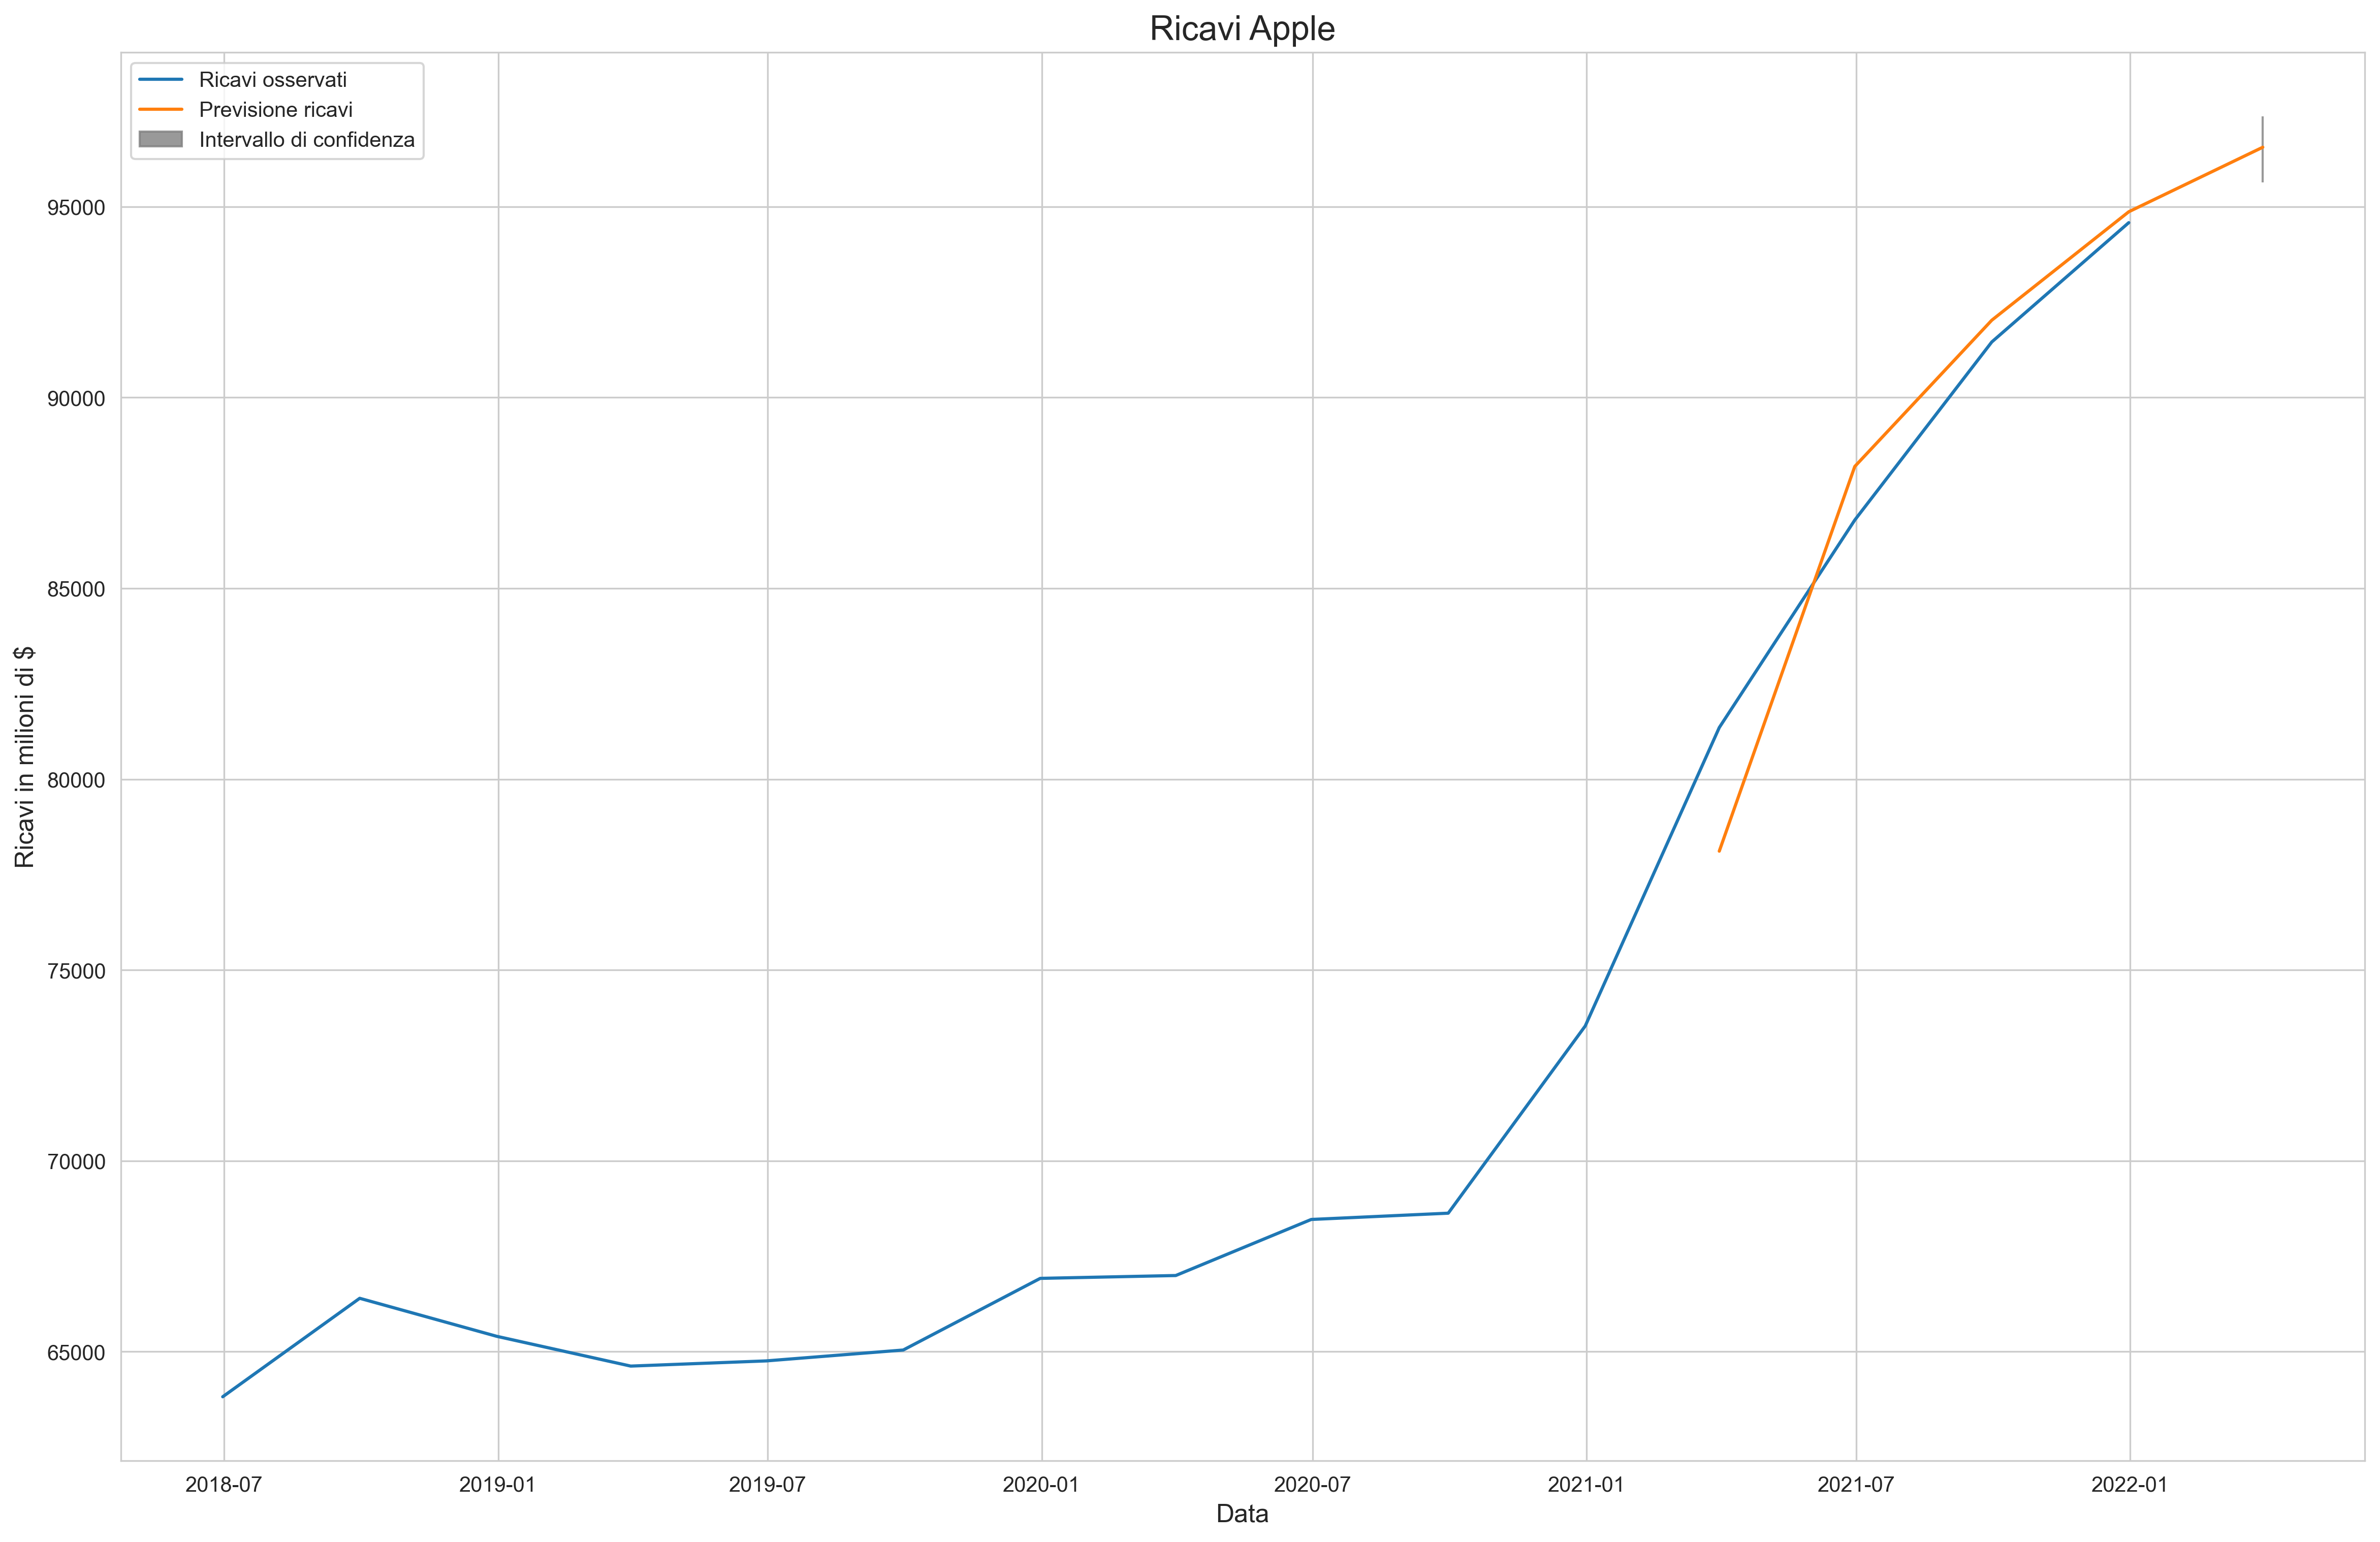

In [435]:
# Imposta lo stile di Seaborn
sns.set_style("whitegrid")

# Crea il plot utilizzando Seaborn
plt.figure(figsize=(19, 12), dpi=300)
sns.lineplot(x=indice, y=Ricavi['Ricavi'], label='Ricavi osservati')
sns.lineplot(x=indice_4, y=Ricavi_4['Pred'], label='Previsione ricavi')
plt.fill_between(indice_f, Ricavi_f['Ricavi_low'], Ricavi_f['Ricavi_up'], color='gray', alpha=0.8, label='Intervallo di confidenza')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Ricavi in milioni di $', fontsize=12)
plt.title('Ricavi Apple', fontsize=16)
plt.legend()
plt.show()